In [92]:
import numpy as np
import pandas as pd
from ast import literal_eval
import pymc3
import arviz as az
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
pd.options.mode.chained_assignment = None  # default='warn'

# Pre-processing of data

In [2]:
def pre_process_input_data(dataframe):
    '''
    dataframe must be pandas dataFrame with appropiate columns...
    '''
    
    dataframe.rename(columns={'Unnamed: 0':'frame'}, inplace=True)

    # convert columns with literal_eval to not have strings anymore
    dataframe.player_pos = dataframe.player_pos.apply(lambda row: literal_eval(row))
    dataframe.visible_obstacles = dataframe.visible_obstacles.apply(lambda row : literal_eval(row))
    dataframe.visible_drift_tiles = dataframe.visible_drift_tiles.apply(lambda row : literal_eval(row))
    
    # adjust time tag
    dataframe['adjusted_time_tag'] = dataframe.time_played + dataframe.time_tag

    ## annotate input data
    
    # input can be either None, "Right", "Left"
    rows_with_input = dataframe[~dataframe["current_input"].isnull()][["frame"]]
    # subsetting columns
    
    # condition for start input
    cond = rows_with_input.frame - rows_with_input.frame.shift(1) >= 2

    # have =1 everywhere condition applies and =0 where not
    rows_with_input["start_input"] = np.where(cond, 1, 0)

    # flag first row also as start input (because we missed it by not taking any rows before that row due to subsetting)
    index = rows_with_input.iloc[0].frame
    rows_with_input.loc[index, "start_input"] = 1.0

    # label all frames of each individual input with number of input
    rows_with_input["N_input"] = (rows_with_input["start_input"] == 1).cumsum()
    
    # joining dataframes
    dataframe = dataframe.merge(rows_with_input, on="frame", how='left')

    ## annotate input switch (strategy change?)
    rows_with_input_direction = dataframe[dataframe["start_input"] == 1][["frame", "current_input"]]

    # condition for input switch
    cond = rows_with_input_direction.current_input != rows_with_input_direction.current_input.shift(1)

    # have =1 everywhere condition applies and =0 where not
    rows_with_input_direction["input_change"] = np.where(cond, 1, 0)
    # drop current_input column for better merge in next step
    rows_with_input_direction.drop(columns="current_input", axis=1, inplace=True)
    
    # joining dataframes
    dataframe = dataframe.merge(rows_with_input_direction, on="frame", how='left')
    
    return dataframe

In [3]:
data = pd.read_csv('input_data/pilot4_output_04.csv', index_col=False)
data = pre_process_input_data(data)
data

,frame,trial,attempt,time_played,time_tag,level_size_y,player_pos,collision,current_input,drift_enabled,...,input_noise_magnitude,input_noise_on,visible_obstacles,adjacent_wall_tiles_x_pos,visible_drift_tiles,SoC,adjusted_time_tag,start_input,N_input,input_change
0,0,5,1,0.000998,2969.977121,9018,"[954, -86]",False,NaN,True,...,NaN,False,[],NaN,[],NaN,2969.978118,NaN,NaN,NaN
1,1,5,1,0.017058,2969.977121,9018,"[954, -82]",False,NaN,True,...,NaN,False,[],NaN,[],NaN,2969.994179,NaN,NaN,NaN
2,2,5,1,0.033623,2969.977121,9018,"[954, -78]",False,NaN,True,...,NaN,False,[],NaN,[],NaN,2970.010743,NaN,NaN,NaN
3,3,5,1,0.049330,2969.977121,9018,"[954, -74]",False,NaN,True,...,NaN,False,[],NaN,[],NaN,2970.026451,NaN,NaN,NaN
4,4,5,1,0.066156,2969.977121,9018,"[954, -70]",False,NaN,True,...,NaN,False,[],NaN,[],NaN,2970.043276,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,1544,5,1,26.968981,2969.977121,9018,"[954, 270]",False,NaN,True,...,NaN,True,[],NaN,[],NaN,2996.946102,NaN,NaN,NaN
1545,1545,5,1,26.985721,2969.977121,9018,"[954, 270]",False,NaN,True,...,NaN,True,[],NaN,[],NaN,2996.962841,NaN,NaN,NaN
1546,1546,5,1,27.001301,2969.977121,9018,"[954, 270]",False,NaN,True,...,NaN,True,[],NaN,[],NaN,2996.978421,NaN,NaN,NaN
1547,1547,5,1,27.022249,2969.977121,9018,"[954, 270]",False,NaN,True,...,NaN,True,[],NaN,[],NaN,2996.999370,NaN,NaN,NaN


In [4]:
#data.iloc[1000]
test = data[~data["current_input"].isnull()]
#test = data[data["start_input"] == 1.0]
test[:50]

,frame,trial,attempt,time_played,time_tag,level_size_y,player_pos,collision,current_input,drift_enabled,...,input_noise_magnitude,input_noise_on,visible_obstacles,adjacent_wall_tiles_x_pos,visible_drift_tiles,SoC,adjusted_time_tag,start_input,N_input,input_change
102,102,5,1,1.673372,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.650492,1.0,1.0,1.0
103,103,5,1,1.689922,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.667043,0.0,1.0,NaN
104,104,5,1,1.705778,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.682899,0.0,1.0,NaN
105,105,5,1,1.721974,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.699094,0.0,1.0,NaN
106,106,5,1,1.737821,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.714942,0.0,1.0,NaN
107,107,5,1,1.753994,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.731115,0.0,1.0,NaN
108,108,5,1,1.770770,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.747891,0.0,1.0,NaN
109,109,5,1,1.786702,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.763823,0.0,1.0,NaN
110,110,5,1,1.802828,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.779948,0.0,1.0,NaN
111,111,5,1,1.818786,2969.977121,9018,"[954, 270]",False,Right,True,...,NaN,True,[],NaN,[],NaN,2971.795906,0.0,1.0,NaN


## Variables of interest

In [5]:
seconds_played = data.iloc[-2].time_played  # second last row because last row is written to df AFTER SoC response given which may take time
seconds_played

27.02224898338318

In [6]:
SoC = data.iloc[-1].SoC
SoC

6.0

In [7]:
crashed = data.iloc[-1].collision
crashed

False

# Eye-tracking data

In [63]:
def calc_saccade_direction(saccade_rows):
    '''
    Need to be given pandas dataframe grouped by N_saccade. 
    Dataframe must have columns of eye positions (e.g. LeftEyeX) and saccade_direction.
    Returned dataframe now holds direction vector of saccade in every row in column saccade direction.
    '''
    
    # x-direction
    left_eye_x_direction = saccade_rows.iloc[-1].LeftEyeX - saccade_rows.iloc[0].LeftEyeX
    right_eye_x_direction = saccade_rows.iloc[-1].RightEyeX - saccade_rows.iloc[0].RightEyeX
    x_direction = (left_eye_x_direction + right_eye_x_direction)/2
    
    # y-direction
    left_eye_y_direction = saccade_rows.iloc[-1].LeftEyeY - saccade_rows.iloc[0].LeftEyeY
    right_eye_y_direction = saccade_rows.iloc[-1].RightEyeY - saccade_rows.iloc[0].RightEyeY
    y_direction = (left_eye_y_direction + right_eye_y_direction)/2
    
    saccade_rows.saccade_direction_x = saccade_rows.apply(lambda x: x_direction, axis=1)
    saccade_rows.saccade_direction_y = saccade_rows.apply(lambda x: y_direction, axis=1)
    saccade_rows.saccade_amplitude = saccade_rows.apply(lambda x: np.sqrt(np.power(x_direction, 2) + np.power(y_direction, 2)), axis=1)
    
    return saccade_rows

In [68]:
# annotate eye_tracking data

def pre_process_eye_data(eye_data):
    
    # adjust time tag to start at 0
    eye_data["time_tag"] = eye_data.TimeTag - eye_data.TimeTag[0]
    
    # annotate binocular fixations
    eye_data["Fixation"] = eye_data.LeftEyeFixationFlag + eye_data.RightEyeFixationFlag
    ## eliminate simultaneous blink and fixation (setting fixation to 0)
    eye_data.Fixation.loc[eye_data.LeftBlink > 0.0] = 0.0
    eye_data.Fixation.loc[eye_data.RightBlink > 0.0] = 0.0
    eye_data.Fixation[eye_data.Fixation > 1] = 1.0
    
    # annotate binocular saccades
    eye_data["Saccade"] = eye_data.LeftEyeSaccadeFlag + eye_data.RightEyeSaccadeFlag
    ## eliminate simultaneous blink and saccades (setting saccade to 0)
    eye_data.Saccade.loc[eye_data.LeftBlink > 0.0] = 0.0
    eye_data.Saccade.loc[eye_data.RightBlink > 0.0] = 0.0
    eye_data.Saccade[eye_data.Saccade > 1] = 1.0
    
    # condition for initiating saccade
    cond = (eye_data.Saccade >= 1.0) & (eye_data.Saccade.shift(1) == 0.0)

    # have =1 everywhere condition applies and =0 where not
    eye_data["saccadeOnset"] = np.where(cond, 1, 0)
    
    # insert N_saccade - counting up saccades
    eye_data["N_saccade"] = (eye_data["saccadeOnset"] == 1).cumsum()
    eye_data.loc[eye_data.Saccade < 1.0, "N_saccade"] = np.nan  # have NaN everywhere where there is no saccade
    
    # insert saccade direction column
    eye_data["saccade_direction_x"] = np.nan
    eye_data["saccade_direction_y"] = np.nan
    eye_data["saccade_amplitude"] = np.nan
    out = eye_data.groupby("N_saccade", dropna=False).apply(calc_saccade_direction)
    
    # set saccade direction to NaN everywhere where there is no saccade
    out.loc[eye_data.Saccade < 1.0, ["saccade_direction_x", "saccade_direction_y"]] = np.nan
    
    # sum up left and right eye positions to converging eye position in x and y dimension
    out["converging_eye_x"] = out.apply(lambda row: (row.LeftEyeX + row.RightEyeX) / 2, axis=1)
    out["converging_eye_y"] = out.apply(lambda row: (row.LeftEyeY + row.RightEyeY) / 2, axis=1)
    
    return out

## pilot 4 run 04

In [76]:
eye_data = pd.read_csv('eye_data/pilot4_eye_tracking_output_04.csv', index_col=False)
eye_data = pre_process_eye_data(eye_data)
eye_data

,TimeTag,LeftEyeX,LeftEyeY,LeftPupilDiameter,RightEyeX,RightEyeY,RightPupilDiameter,DigitalIn,LeftBlink,RightBlink,...,time_tag,Fixation,Saccade,saccadeOnset,N_saccade,saccade_direction_x,saccade_direction_y,saccade_amplitude,converging_eye_x,converging_eye_y
0,2969.9765,-547.756897,-385.260803,54.722656,-595.288391,-386.468689,58.429688,16777215.0,0.0,0.0,...,0.0000,1.0,0.0,0,NaN,NaN,NaN,NaN,-571.522644,-385.864746
1,2969.9770,-547.953125,-385.516724,54.714844,-595.695862,-386.805969,58.429688,16777215.0,0.0,0.0,...,0.0005,1.0,0.0,0,NaN,NaN,NaN,NaN,-571.824493,-386.161346
2,2969.9775,-547.767517,-385.048157,54.703125,-595.755981,-386.637878,58.406250,16777215.0,0.0,0.0,...,0.0010,1.0,0.0,0,NaN,NaN,NaN,NaN,-571.761749,-385.843018
3,2969.9780,-547.695251,-384.919312,54.714844,-595.575928,-387.251343,58.414062,16777215.0,0.0,0.0,...,0.0015,1.0,0.0,0,NaN,NaN,NaN,NaN,-571.635590,-386.085327
4,2969.9785,-547.612427,-385.003113,54.707031,-595.555298,-387.167236,58.410156,16777215.0,0.0,0.0,...,0.0020,1.0,0.0,0,NaN,NaN,NaN,NaN,-571.583862,-386.085175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56891,2998.4220,NaN,NaN,9999.000000,NaN,NaN,9999.000000,16777215.0,1.0,1.0,...,28.4455,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
56892,2998.4225,NaN,NaN,9999.000000,NaN,NaN,9999.000000,16777215.0,1.0,1.0,...,28.4460,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
56893,2998.4230,NaN,NaN,9999.000000,NaN,NaN,9999.000000,16777215.0,1.0,1.0,...,28.4465,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
56894,2998.4235,NaN,NaN,9999.000000,NaN,NaN,9999.000000,16777215.0,1.0,1.0,...,28.4470,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
saccades = eye_data.loc[eye_data["saccadeOnset"] == 1]

progressive_saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
progressive_saccades

,TimeTag,LeftEyeX,LeftEyeY,LeftPupilDiameter,RightEyeX,RightEyeY,RightPupilDiameter,DigitalIn,LeftBlink,RightBlink,...,time_tag,Fixation,Saccade,saccadeOnset,N_saccade,saccade_direction_x,saccade_direction_y,saccade_amplitude,converging_eye_x,converging_eye_y
256,2970.1045,-419.222229,-311.874268,55.871094,-506.637970,-335.133789,59.437500,16777215.0,0.0,0.0,...,0.128,0.0,1.0,1,1.0,235.702103,177.948273,295.332133,-462.930099,-323.504028
470,2970.2115,154.772461,-150.782715,48.457031,138.180054,-143.437134,53.589844,16777215.0,0.0,0.0,...,0.235,0.0,1.0,1,3.0,-14.474182,56.629028,58.449541,146.476257,-147.109924
25326,2982.6395,-1.821350,91.348389,62.398438,58.665833,-17.923828,59.953125,16777215.0,0.0,0.0,...,12.663,1.0,1.0,1,8.0,-18.899200,37.202576,41.727825,28.422241,36.712280


In [78]:
len(progressive_saccades)

3

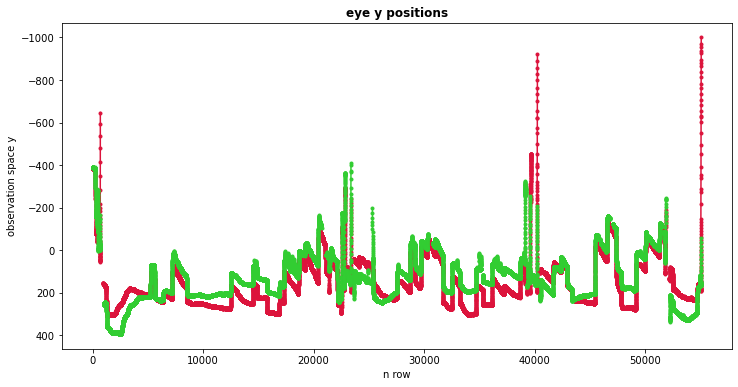

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"eye y positions", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("n row")
ax.set_ylabel("observation space y")

plt.gca().invert_yaxis()

# Plotting
colors = ["crimson", "limegreen"]

ax.plot(eye_data.LeftEyeY, marker=".", color=colors[0])
ax.plot(eye_data.RightEyeY, marker=".", color=colors[1])

In [12]:
#eye_data[eye_data["Saccade"] == 0.0]

# Combining KDEs of input and eye tracking data

In [13]:
# function for estimating point of maximum for kde
def point_estimate(data):
    kde = st.gaussian_kde(data)  # gaussian kernel
    n_samples = 1000  # arbitrarily high number of samples
    samples = np.linspace(min(data), max(data), n_samples)  # sampling
    probs = kde.evaluate(samples)
    point_estimate_y = max(probs)
    point_estimate_index = probs.argmax()
    point_estimate_x = samples[point_estimate_index]
    hdi = az.hdi(samples, hdi_prob=0.25)  # compute hpdi (I went for the smallest interval which contains 25% of the mass)

    return point_estimate_x, point_estimate_y, hdi[0], hdi[1]

In [14]:
    def plot_kde_combined(code="pilot4", n_run=0, safe_plot=True):

        # load data (with input data being button presses and eye data being eye tracking output)
        input_data = pd.read_csv(f'input_data/{code}_output_{n_run:0>2}.csv', index_col=False)
        input_data = pre_process_input_data(input_data)

        eye_data = pd.read_csv(f'eye_data/{code}_eye_tracking_output_{n_run:0>2}.csv', index_col=False)
        eye_data = pre_process_eye_data(eye_data)

        # reducing data to only respective events of interest
        inputs = input_data[input_data["start_input"] == 1.0]
        saccades = eye_data[eye_data["saccadeOnset"] == 1.0]

        # define arrays of time tags for respective data
        input_data_array = np.asarray(inputs.time_played)
        eye_data_array = np.asarray(saccades.time_tag)

        # define point dataframes
        input_data_points = {'x': input_data_array, 'y': [0]*len(input_data_array)}
        input_data_points = pd.DataFrame(data=input_data_points)
        # dataframe for eye_data points is generated down below...

        # compute hpdi (I went for the smallest interval which contains 25% of the mass)
        input_data_hpdi_bounds = az.hdi(input_data_array, 0.25)
        eye_data_hpdi_bounds = az.hdi(eye_data_array, 0.25) 

        # plot boundaries:
        lbound = 0
        ubound = input_data.iloc[-2].time_played  # second last row because last row is written to df AFTER SoC response given which may take time

        # instatiate KDEs
        kde_init = np.linspace(lbound, ubound, 100)

        input_data_kde = st.gaussian_kde(input_data_array)
        eye_data_kde = st.gaussian_kde(eye_data_array)

        # Grid
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_title(f"Densities of events for trial {inputs.iloc[0].trial} (drift enabled = {inputs.iloc[0].drift_enabled}, input noise = {inputs.iloc[0].input_noise_magnitude}, crashed = {input_data.iloc[-1].collision})", fontdict={"fontweight": "bold"})

        # axis labels
        ax.set_xlabel("Time played")
        ax.set_ylabel("Density")

        ax.set_xlim([lbound, ubound])

        xaxis = np.linspace(lbound, ubound, 10)
        ax.set_xticks(xaxis)

        # Plotting
        colors = ["crimson", "limegreen"]

        ax.plot(kde_init, input_data_kde(kde_init), color=colors[0], label='input data')
        #ax.fill_between(kde_init, input_data_kde(kde_init), step="mid", alpha=0.3, color=colors[0])
        ax.scatter(input_data_points.x, input_data_points.y, marker=".", color=colors[0])

        ax.plot(kde_init, eye_data_kde(kde_init), color=colors[1], label='eye movement data')
        #ax.fill_between(kde_init, eye_data_kde(kde_init), step="mid", alpha=0.3, color=colors[1])
        
        # define dataframe for points of eye_data ( now because we can retrieve y-axis limits at this point)
        y_max = ax.get_ylim()[1]  # 0: bottom; 1: top
        eye_data_points = {'x': eye_data_array, 'y': [y_max/99]*len(eye_data_array)}  # y_max/99 to plot these a bit above input data points
        eye_data_points = pd.DataFrame(data=eye_data_points)
        ax.scatter(eye_data_points.x, eye_data_points.y, marker=".", color=colors[1])


        # HPDIs:
        point_estimate_input_data = point_estimate(inputs.time_played)
        #ax.axvspan(point_estimate_input_data[2], point_estimate_input_data[3], alpha=0.3, color=colors[0])
        plt.vlines(point_estimate_input_data[0], ymin=0, ymax=point_estimate_input_data[1], color=colors[0])

        point_estimate_eye_data = point_estimate(saccades.time_tag)
        #ax.axvspan(point_estimate_eye_data[2], point_estimate_eye_data[3], alpha=0.3, color=colors[1])
        plt.vlines(point_estimate_eye_data[0], ymin=0, ymax=point_estimate_eye_data[1], color=colors[1])

        ax.legend()

        if safe_plot:
            plt.savefig(f"kde_plots/Event densities trial {inputs.iloc[0].trial} run {n_run}", dpi=300)
            plt.close()

In [15]:
N_run = 43

for run in np.arange(N_run):
    #plot_kde_combined(code="pilot4", n_run=run, safe_plot=False)
    pass

# Eyes fixating on ship

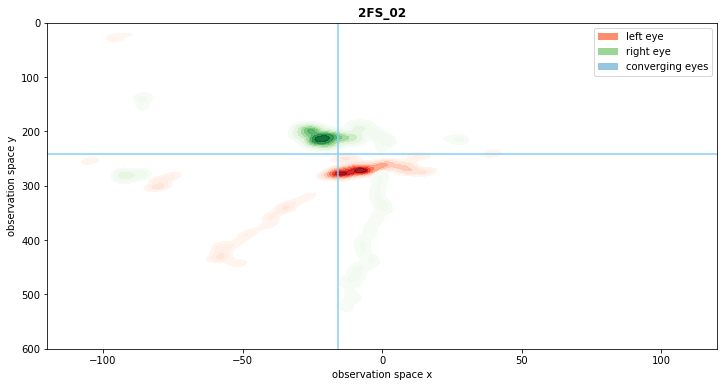

In [35]:
code = "2FS_02"
only_ship_data = pd.read_csv(f'eye_data/only_ship_eye_tracking_output_{code}.csv', index_col=False)
only_ship_data = pre_process_eye_data(only_ship_data)

fixations = only_ship_data[only_ship_data["Fixation"] == 1.0]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"{code}", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("observation space x")
ax.set_ylabel("observation space y")

ax.set_xlim([-120, 120])
ax.set_ylim([0, 600])

plt.gca().invert_yaxis()

# Plotting
colors = ["crimson", "limegreen"]

#ax.scatter(fixations.LeftEyeX, fixations.LeftEyeY, marker=".", color=colors[0], alpha=0.3)
#ax.scatter(fixations.RightEyeX, fixations.RightEyeY, marker=".", color=colors[1], alpha=0.3)

heatmap_left = sns.kdeplot(x=fixations.LeftEyeX, 
                           y=fixations.LeftEyeY, 
                           cmap="Reds",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

heatmap_right = sns.kdeplot(x=fixations.RightEyeX, 
                           y=fixations.RightEyeY, 
                           cmap="Greens",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

y_coord = point_estimate(fixations.converging_eye_y)[0]
ax.axhline(y_coord, color="lightskyblue")
x_coord = point_estimate(fixations.converging_eye_x)[0]
ax.axvline(x_coord, color="lightskyblue")

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="left eye"),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="right eye"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="converging eyes")]
ax.legend(handles=handles)

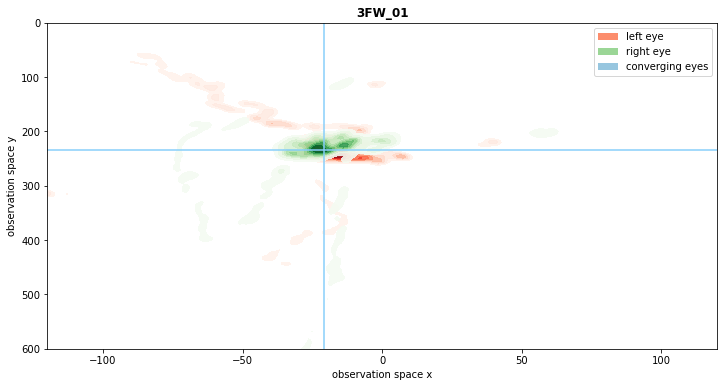

In [34]:
code = "3FW_01"
only_ship_data = pd.read_csv(f'eye_data/only_ship_eye_tracking_output_{code}.csv', index_col=False)
only_ship_data = pre_process_eye_data(only_ship_data)

fixations = only_ship_data[only_ship_data["Fixation"] == 1.0]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"{code}", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("observation space x")
ax.set_ylabel("observation space y")

ax.set_xlim([-120, 120])
ax.set_ylim([0, 600])

plt.gca().invert_yaxis()

# Plotting
colors = ["crimson", "limegreen"]

#ax.scatter(fixations.LeftEyeX, fixations.LeftEyeY, marker=".", color=colors[0], alpha=0.3)
#ax.scatter(fixations.RightEyeX, fixations.RightEyeY, marker=".", color=colors[1], alpha=0.3)

heatmap_left = sns.kdeplot(x=fixations.LeftEyeX, 
                           y=fixations.LeftEyeY, 
                           cmap="Reds",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

heatmap_right = sns.kdeplot(x=fixations.RightEyeX, 
                           y=fixations.RightEyeY, 
                           cmap="Greens",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

y_coord = point_estimate(fixations.converging_eye_y)[0]
ax.axhline(y_coord, color="lightskyblue")
x_coord = point_estimate(fixations.converging_eye_x)[0]
ax.axvline(x_coord, color="lightskyblue")

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="left eye"),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="right eye"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="converging eyes")]
ax.legend(handles=handles)

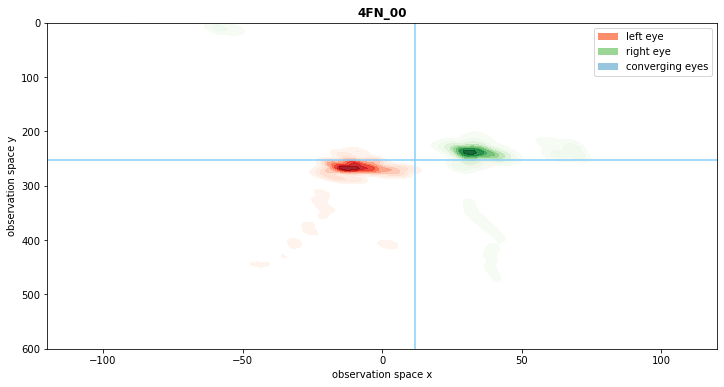

In [33]:
code = "4FN_00"
only_ship_data = pd.read_csv(f'eye_data/only_ship_eye_tracking_output_{code}.csv', index_col=False)
only_ship_data = pre_process_eye_data(only_ship_data)

fixations = only_ship_data[only_ship_data["Fixation"] == 1.0]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"{code}", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("observation space x")
ax.set_ylabel("observation space y")

ax.set_xlim([-120, 120])
ax.set_ylim([0, 600])

plt.gca().invert_yaxis()

# Plotting
colors = ["crimson", "limegreen"]

#ax.scatter(fixations.LeftEyeX, fixations.LeftEyeY, marker=".", color=colors[0], alpha=0.3)
#ax.scatter(fixations.RightEyeX, fixations.RightEyeY, marker=".", color=colors[1], alpha=0.3)

heatmap_left = sns.kdeplot(x=fixations.LeftEyeX, 
                           y=fixations.LeftEyeY, 
                           cmap="Reds",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

heatmap_right = sns.kdeplot(x=fixations.RightEyeX, 
                           y=fixations.RightEyeY, 
                           cmap="Greens",
                           shade=True,
                           alpha=0.9,
                           bw_adjust=0.4)

y_coord = point_estimate(fixations.converging_eye_y)[0]
ax.axhline(y_coord, color="lightskyblue")
x_coord = point_estimate(fixations.converging_eye_x)[0]
ax.axvline(x_coord, color="lightskyblue")

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="left eye"),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="right eye"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="converging eyes")]
ax.legend(handles=handles)

For all three trials the heatmaps of both individual eyes converge on x = 0 and y = 250. This position is definitely inhabited by the spaceship. We will therefore use **[0, 250]** as point of spaceship for further analysis of the experiment.

# Finding runs that can be compared (same trial, same drift, different input_noise, but no crash)

In [19]:
code="pilot4"

N_run = 43

levels = []
crashs = []
drifts = []
input_noise_magnitudes = []

for n_run in np.arange(N_run+1):
    input_data = pd.read_csv(f'input_data/{code}_output_{n_run:0>2}.csv', index_col=False)
    input_data = pre_process_input_data(input_data)
    levels.append(input_data.iloc[-1].trial)
    crashs.append(input_data.iloc[-1].collision)
    drifts.append(input_data.iloc[-1].drift_enabled)
    input_noise_magnitudes.append(input_data.iloc[-1].input_noise_magnitude)
    
trial_config = pd.DataFrame(columns=['level', 'crash', 'drift', 'input_noise'])
trial_config.level = levels
trial_config.crash = crashs
trial_config.drift = drifts
trial_config.input_noise = input_noise_magnitudes

trial_config    

,level,crash,drift,input_noise
0,3,False,True,strong
1,4,False,True,strong
2,6,True,True,weak
3,6,False,False,NaN
4,5,False,True,NaN
5,3,False,True,NaN
6,2,False,True,strong
7,6,True,True,strong
8,6,True,True,NaN
9,1,False,False,weak


In [20]:
trial_config_no_crashs = trial_config[trial_config.crash == False]

grouped = trial_config_no_crashs.groupby(["level", "drift"])
for name_of_the_group, group in grouped:
    print(name_of_the_group)
    print(group)

(1, False)
    level  crash  drift input_noise
9       1  False  False        weak
13      1  False  False         NaN
24      1  False  False      strong
(1, True)
    level  crash  drift input_noise
26      1  False   True        weak
28      1  False   True         NaN
29      1  False   True      strong
(2, False)
    level  crash  drift input_noise
12      2  False  False      strong
21      2  False  False         NaN
34      2  False  False        weak
(2, True)
    level  crash  drift input_noise
6       2  False   True      strong
10      2  False   True         NaN
16      2  False   True        weak
(3, False)
    level  crash  drift input_noise
14      3  False  False        weak
25      3  False  False         NaN
39      3  False  False      strong
(3, True)
    level  crash  drift input_noise
0       3  False   True      strong
5       3  False   True         NaN
33      3  False   True        weak
(4, False)
    level  crash  drift input_noise
11      4  False  False   

In [21]:
trial_config_combinations = [[9, 13, 24], [26, 28, 29], [12, 21, 34], [6, 10, 16], [14, 25, 39], [0, 5, 33], [11, 19, 40], [1, 20, 22], [18, 35, 42], [4, 15, 43], [3, 37, 41], [31, 38]]
len(trial_config_combinations)

12

In [22]:
trial_config_combinations[10]

[3, 37, 41]

# Eye resting position (differences in y dimension)

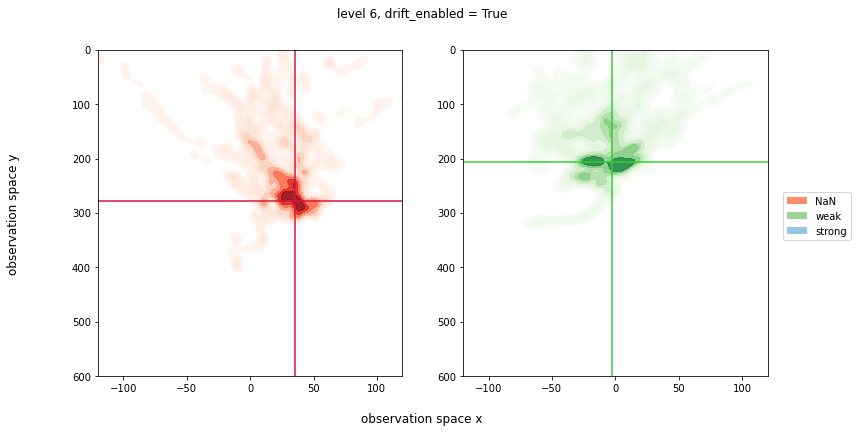

In [23]:
runs = [38, 31]

fig, axs = plt.subplots(1, len(runs), figsize=(12, 6))
fig.suptitle(f"level 6, drift_enabled = True")

fig.supxlabel("observation space x")
fig.supylabel("observation space y")

# Plotting
colors = ["crimson", "limegreen", "lightskyblue"]
color_maps = ["Reds", "Greens", "Blues"]
input_noise_magnitude = ["NaN", "weak", "strong"]
counter = 0

for run, ax in zip(runs, axs.ravel()):
    
    # axis labels
    ax.set_xlabel(" ")
    ax.set_ylabel(" ")

    ax.set_xlim([-120, 120])
    ax.set_ylim([0, 600])

    ax.invert_yaxis()

    eye_data = pd.read_csv(f'eye_data/pilot4_eye_tracking_output_{run:0>2}.csv', index_col=False)
    eye_data = pre_process_eye_data(eye_data)

    fixations = eye_data[eye_data["Fixation"] == 1.0]

    heatmap_left = sns.kdeplot(x=fixations.converging_eye_x, 
                               y=fixations.converging_eye_y, 
                               cmap=color_maps[counter],
                               shade=True,
                               alpha=0.9,
                               bw_adjust=0.4, 
                               ax=ax)
    
    y_coord = point_estimate(fixations.converging_eye_y)[0]
    ax.axhline(y_coord, color=colors[counter])
    x_coord = point_estimate(fixations.converging_eye_x)[0]
    ax.axvline(x_coord, color=colors[counter])
    
    counter += 1

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=input_noise_magnitude[0]),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label=input_noise_magnitude[1]),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label=input_noise_magnitude[2])]
fig.legend(handles=handles, loc='center right')

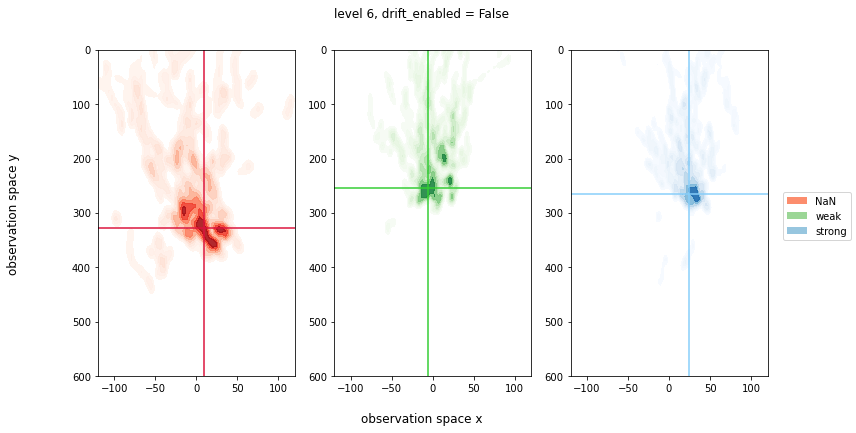

In [24]:
runs = [3, 41, 37]

fig, axs = plt.subplots(1, len(runs), figsize=(12, 6))
fig.suptitle(f"level 6, drift_enabled = False")

fig.supxlabel("observation space x")
fig.supylabel("observation space y")

# Plotting
colors = ["crimson", "limegreen", "lightskyblue"]
color_maps = ["Reds", "Greens", "Blues"]
input_noise_magnitude = ["NaN", "weak", "strong"]
counter = 0

for run, ax in zip(runs, axs.ravel()):
    
    # axis labels
    ax.set_xlabel(" ")
    ax.set_ylabel(" ")

    ax.set_xlim([-120, 120])
    ax.set_ylim([0, 600])

    ax.invert_yaxis()

    eye_data = pd.read_csv(f'eye_data/pilot4_eye_tracking_output_{run:0>2}.csv', index_col=False)
    eye_data = pre_process_eye_data(eye_data)

    fixations = eye_data[eye_data["Fixation"] == 1.0]

    heatmap_left = sns.kdeplot(x=fixations.converging_eye_x, 
                               y=fixations.converging_eye_y, 
                               cmap=color_maps[counter],
                               shade=True,
                               alpha=0.9,
                               bw_adjust=0.4, 
                               ax=ax)
    
    y_coord = point_estimate(fixations.converging_eye_y)[0]
    ax.axhline(y_coord, color=colors[counter])
    x_coord = point_estimate(fixations.converging_eye_x)[0]
    ax.axvline(x_coord, color=colors[counter])
    
    counter += 1

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=input_noise_magnitude[0]),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label=input_noise_magnitude[1]),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label=input_noise_magnitude[2])]
fig.legend(handles=handles, loc='center right')

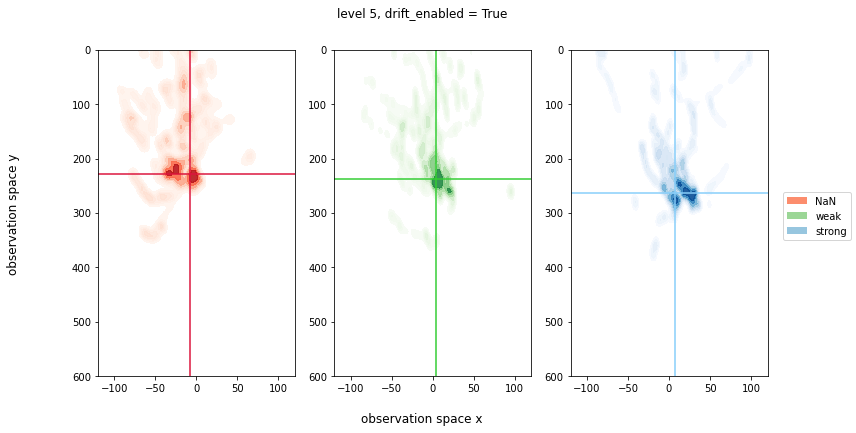

In [25]:
runs = [4, 43, 15]

fig, axs = plt.subplots(1, len(runs), figsize=(12, 6))
fig.suptitle(f"level 5, drift_enabled = True")

fig.supxlabel("observation space x")
fig.supylabel("observation space y")

# Plotting
colors = ["crimson", "limegreen", "lightskyblue"]
color_maps = ["Reds", "Greens", "Blues"]
input_noise_magnitude = ["NaN", "weak", "strong"]
counter = 0

for run, ax in zip(runs, axs.ravel()):
    
    # axis labels
    ax.set_xlabel(" ")
    ax.set_ylabel(" ")

    ax.set_xlim([-120, 120])
    ax.set_ylim([0, 600])

    ax.invert_yaxis()

    eye_data = pd.read_csv(f'eye_data/pilot4_eye_tracking_output_{run:0>2}.csv', index_col=False)
    eye_data = pre_process_eye_data(eye_data)

    fixations = eye_data[eye_data["Fixation"] == 1.0]

    heatmap_left = sns.kdeplot(x=fixations.converging_eye_x, 
                               y=fixations.converging_eye_y, 
                               cmap=color_maps[counter],
                               shade=True,
                               alpha=0.9,
                               bw_adjust=0.4, 
                               ax=ax)
    
    y_coord = point_estimate(fixations.converging_eye_y)[0]
    ax.axhline(y_coord, color=colors[counter])
    x_coord = point_estimate(fixations.converging_eye_x)[0]
    ax.axvline(x_coord, color=colors[counter])
    
    counter += 1

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=input_noise_magnitude[0]),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label=input_noise_magnitude[1]),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label=input_noise_magnitude[2])]
fig.legend(handles=handles, loc='center right')

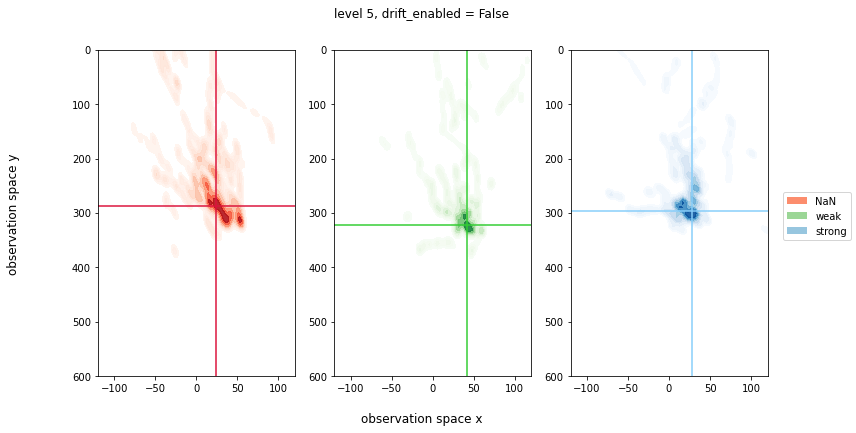

In [26]:
runs = [42, 35, 18]

fig, axs = plt.subplots(1, len(runs), figsize=(12, 6))
fig.suptitle(f"level 5, drift_enabled = False")

fig.supxlabel("observation space x")
fig.supylabel("observation space y")

# Plotting
colors = ["crimson", "limegreen", "lightskyblue"]
color_maps = ["Reds", "Greens", "Blues"]
input_noise_magnitude = ["NaN", "weak", "strong"]
counter = 0

for run, ax in zip(runs, axs.ravel()):
    
    # axis labels
    ax.set_xlabel(" ")
    ax.set_ylabel(" ")

    ax.set_xlim([-120, 120])
    ax.set_ylim([0, 600])

    ax.invert_yaxis()

    eye_data = pd.read_csv(f'eye_data/pilot4_eye_tracking_output_{run:0>2}.csv', index_col=False)
    eye_data = pre_process_eye_data(eye_data)

    fixations = eye_data[eye_data["Fixation"] == 1.0]

    heatmap_left = sns.kdeplot(x=fixations.converging_eye_x, 
                               y=fixations.converging_eye_y, 
                               cmap=color_maps[counter],
                               shade=True,
                               alpha=0.9,
                               bw_adjust=0.4, 
                               ax=ax)
    
    y_coord = point_estimate(fixations.converging_eye_y)[0]
    ax.axhline(y_coord, color=colors[counter])
    x_coord = point_estimate(fixations.converging_eye_x)[0]
    ax.axvline(x_coord, color=colors[counter])
    
    counter += 1

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=input_noise_magnitude[0]),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label=input_noise_magnitude[1]),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label=input_noise_magnitude[2])]
fig.legend(handles=handles, loc='center right')

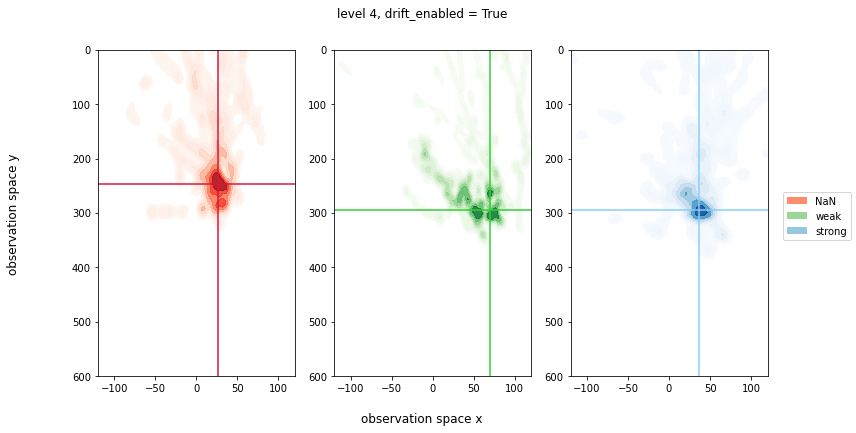

In [27]:
runs = [20, 22, 1]

fig, axs = plt.subplots(1, len(runs), figsize=(12, 6))
fig.suptitle(f"level 4, drift_enabled = True")

fig.supxlabel("observation space x")
fig.supylabel("observation space y")

# Plotting
colors = ["crimson", "limegreen", "lightskyblue"]
color_maps = ["Reds", "Greens", "Blues"]
input_noise_magnitude = ["NaN", "weak", "strong"]
counter = 0

for run, ax in zip(runs, axs.ravel()):
    
    # axis labels
    ax.set_xlabel(" ")
    ax.set_ylabel(" ")

    ax.set_xlim([-120, 120])
    ax.set_ylim([0, 600])

    ax.invert_yaxis()

    eye_data = pd.read_csv(f'eye_data/pilot4_eye_tracking_output_{run:0>2}.csv', index_col=False)
    eye_data = pre_process_eye_data(eye_data)

    fixations = eye_data[eye_data["Fixation"] == 1.0]

    heatmap_left = sns.kdeplot(x=fixations.converging_eye_x, 
                               y=fixations.converging_eye_y, 
                               cmap=color_maps[counter],
                               shade=True,
                               alpha=0.9,
                               bw_adjust=0.4, 
                               ax=ax)
    
    y_coord = point_estimate(fixations.converging_eye_y)[0]
    ax.axhline(y_coord, color=colors[counter])
    x_coord = point_estimate(fixations.converging_eye_x)[0]
    ax.axvline(x_coord, color=colors[counter])
    
    counter += 1

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=input_noise_magnitude[0]),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label=input_noise_magnitude[1]),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label=input_noise_magnitude[2])]
fig.legend(handles=handles, loc='center right')

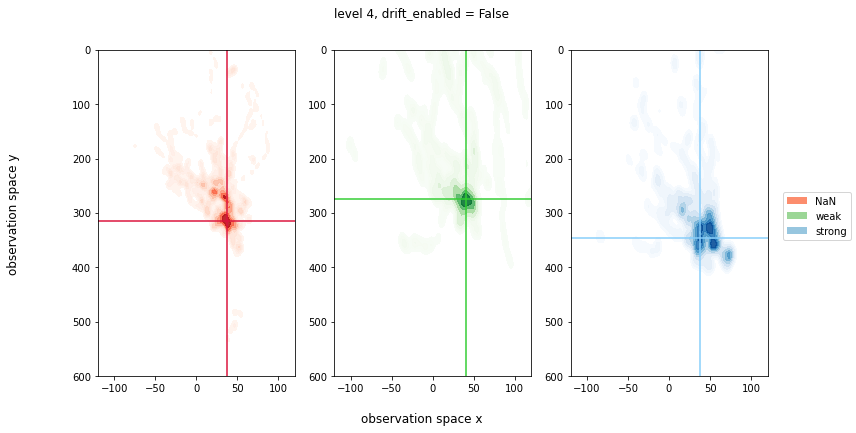

In [28]:
runs = [40, 19, 11]

fig, axs = plt.subplots(1, len(runs), figsize=(12, 6))
fig.suptitle(f"level 4, drift_enabled = False")

fig.supxlabel("observation space x")
fig.supylabel("observation space y")

# Plotting
colors = ["crimson", "limegreen", "lightskyblue"]
color_maps = ["Reds", "Greens", "Blues"]
input_noise_magnitude = ["NaN", "weak", "strong"]
counter = 0

for run, ax in zip(runs, axs.ravel()):
    
    # axis labels
    ax.set_xlabel(" ")
    ax.set_ylabel(" ")

    ax.set_xlim([-120, 120])
    ax.set_ylim([0, 600])

    ax.invert_yaxis()

    eye_data = pd.read_csv(f'eye_data/pilot4_eye_tracking_output_{run:0>2}.csv', index_col=False)
    eye_data = pre_process_eye_data(eye_data)

    fixations = eye_data[eye_data["Fixation"] == 1.0]

    heatmap_left = sns.kdeplot(x=fixations.converging_eye_x, 
                               y=fixations.converging_eye_y, 
                               cmap=color_maps[counter],
                               shade=True,
                               alpha=0.9,
                               bw_adjust=0.4, 
                               ax=ax)
    
    y_coord = point_estimate(fixations.converging_eye_y)[0]
    ax.axhline(y_coord, color=colors[counter])
    x_coord = point_estimate(fixations.converging_eye_x)[0]
    ax.axvline(x_coord, color=colors[counter])
    
    counter += 1

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=input_noise_magnitude[0]),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label=input_noise_magnitude[1]),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label=input_noise_magnitude[2])]
fig.legend(handles=handles, loc='center right')

# saccade amplitudes

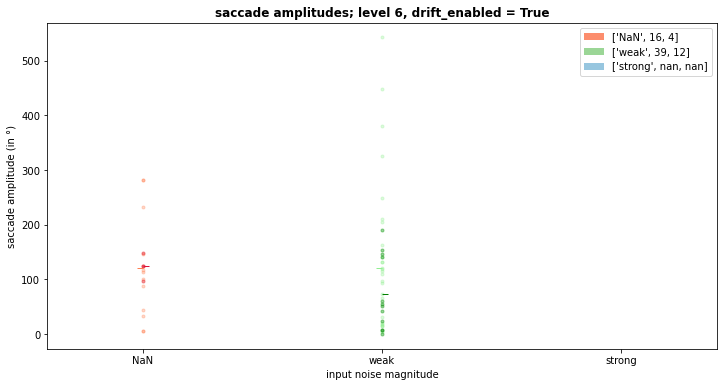

In [96]:
runs = [38, 31]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"saccade amplitudes; level 6, drift_enabled = True", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("input noise magnitude")
ax.set_ylabel("saccade amplitude (in °)")

ax.set_xlim([-70, 70])
ax.set_xticks([-50, 0, 50])
ax.set_xticklabels(["NaN", "weak", "strong"])

# Plotting
colors = ["coral", "lightgreen", "royalblue"]
colors_p = ["crimson", "green", "blue"]
color_maps = ["Reds", "Greens", "Blues"]
input_noise_magnitude = ["NaN", "weak", "strong"]
offset = [-50, 0, 50]
n_saccades = [np.nan, np.nan, np.nan]
n_progressive_saccades = [np.nan, np.nan, np.nan]

counter = 0

for run in runs:
    eye_data = pd.read_csv(f'eye_data/pilot4_eye_tracking_output_{run:0>2}.csv', index_col=False)
    eye_data = pre_process_eye_data(eye_data)
    
    # all kinds of saccades
    saccades = eye_data[eye_data["saccadeOnset"] >= 1]
    n_saccades[counter] = len(saccades)
    plot_labels = [offset[counter]]* len(saccades)
    saccades["plot_label"] = [offset[counter]]* len(saccades)
    # progressive saccades
    progressive_saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
    n_progressive_saccades[counter] = len(progressive_saccades)
    
    # draw on canvas
    ax.scatter(saccades.plot_label, saccades.saccade_amplitude, marker=".", color=colors[counter], alpha=0.3)
    ax.plot(offset[counter], np.mean(saccades.saccade_amplitude), marker=0, color=colors[counter], alpha=1.0)
    
    ax.scatter(progressive_saccades.plot_label, progressive_saccades.saccade_amplitude, marker=".", color=colors_p[counter], alpha=0.3)
    ax.plot(offset[counter], np.mean(progressive_saccades.saccade_amplitude), marker=1, color=colors_p[counter], alpha=1.0)
    
    counter += 1

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=[input_noise_magnitude[0], n_saccades[0], n_progressive_saccades[0]]),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label=[input_noise_magnitude[1], n_saccades[1], n_progressive_saccades[1]]),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label=[input_noise_magnitude[2], n_saccades[2], n_progressive_saccades[2]])]
ax.legend(handles=handles)

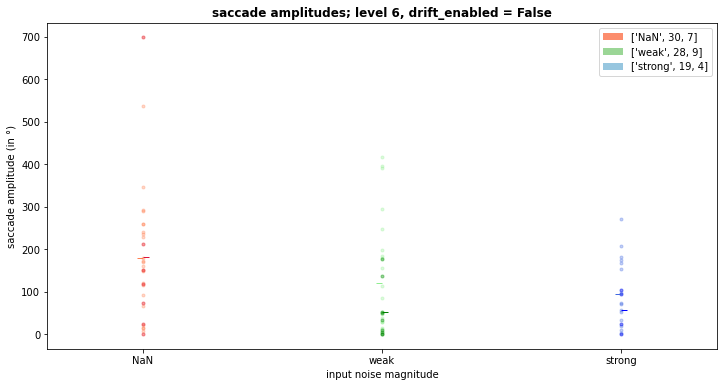

In [95]:
runs = [3, 41, 37]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"saccade amplitudes; level 6, drift_enabled = False", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("input noise magnitude")
ax.set_ylabel("saccade amplitude (in °)")

ax.set_xlim([-70, 70])
ax.set_xticks([-50, 0, 50])
ax.set_xticklabels(["NaN", "weak", "strong"])

# Plotting
colors = ["coral", "lightgreen", "royalblue"]
colors_p = ["crimson", "green", "blue"]
color_maps = ["Reds", "Greens", "Blues"]
input_noise_magnitude = ["NaN", "weak", "strong"]
offset = [-50, 0, 50]
n_saccades = [np.nan, np.nan, np.nan]
n_progressive_saccades = [np.nan, np.nan, np.nan]

counter = 0

for run in runs:
    eye_data = pd.read_csv(f'eye_data/pilot4_eye_tracking_output_{run:0>2}.csv', index_col=False)
    eye_data = pre_process_eye_data(eye_data)
    
    # all kinds of saccades
    saccades = eye_data[eye_data["saccadeOnset"] >= 1]
    n_saccades[counter] = len(saccades)
    plot_labels = [offset[counter]]* len(saccades)
    saccades["plot_label"] = [offset[counter]]* len(saccades)
    # progressive saccades
    progressive_saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
    n_progressive_saccades[counter] = len(progressive_saccades)
    
    # draw on canvas
    ax.scatter(saccades.plot_label, saccades.saccade_amplitude, marker=".", color=colors[counter], alpha=0.3)
    ax.plot(offset[counter], np.mean(saccades.saccade_amplitude), marker=0, color=colors[counter], alpha=1.0)
    
    ax.scatter(progressive_saccades.plot_label, progressive_saccades.saccade_amplitude, marker=".", color=colors_p[counter], alpha=0.3)
    ax.plot(offset[counter], np.mean(progressive_saccades.saccade_amplitude), marker=1, color=colors_p[counter], alpha=1.0)
    
    counter += 1

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=[input_noise_magnitude[0], n_saccades[0], n_progressive_saccades[0]]),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label=[input_noise_magnitude[1], n_saccades[1], n_progressive_saccades[1]]),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label=[input_noise_magnitude[2], n_saccades[2], n_progressive_saccades[2]])]
ax.legend(handles=handles)

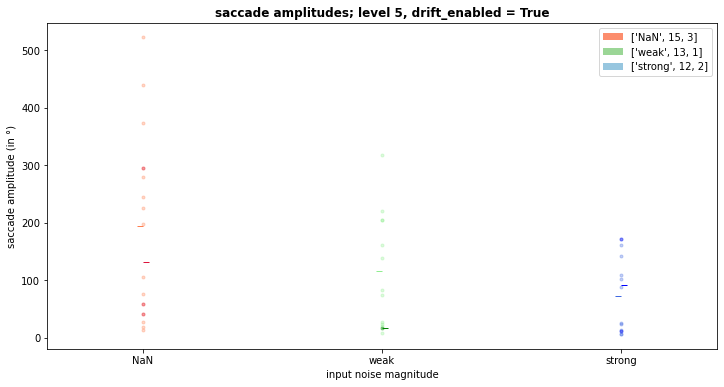

In [97]:
runs = [4, 43, 15]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"saccade amplitudes; level 5, drift_enabled = True", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("input noise magnitude")
ax.set_ylabel("saccade amplitude (in °)")

ax.set_xlim([-70, 70])
ax.set_xticks([-50, 0, 50])
ax.set_xticklabels(["NaN", "weak", "strong"])

# Plotting
colors = ["coral", "lightgreen", "royalblue"]
colors_p = ["crimson", "green", "blue"]
color_maps = ["Reds", "Greens", "Blues"]
input_noise_magnitude = ["NaN", "weak", "strong"]
offset = [-50, 0, 50]
n_saccades = [np.nan, np.nan, np.nan]
n_progressive_saccades = [np.nan, np.nan, np.nan]

counter = 0

for run in runs:
    eye_data = pd.read_csv(f'eye_data/pilot4_eye_tracking_output_{run:0>2}.csv', index_col=False)
    eye_data = pre_process_eye_data(eye_data)
    
    # all kinds of saccades
    saccades = eye_data[eye_data["saccadeOnset"] >= 1]
    n_saccades[counter] = len(saccades)
    plot_labels = [offset[counter]]* len(saccades)
    saccades["plot_label"] = [offset[counter]]* len(saccades)
    # progressive saccades
    progressive_saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
    n_progressive_saccades[counter] = len(progressive_saccades)
    
    # draw on canvas
    ax.scatter(saccades.plot_label, saccades.saccade_amplitude, marker=".", color=colors[counter], alpha=0.3)
    ax.plot(offset[counter], np.mean(saccades.saccade_amplitude), marker=0, color=colors[counter], alpha=1.0)
    
    ax.scatter(progressive_saccades.plot_label, progressive_saccades.saccade_amplitude, marker=".", color=colors_p[counter], alpha=0.3)
    ax.plot(offset[counter], np.mean(progressive_saccades.saccade_amplitude), marker=1, color=colors_p[counter], alpha=1.0)
    
    counter += 1

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=[input_noise_magnitude[0], n_saccades[0], n_progressive_saccades[0]]),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label=[input_noise_magnitude[1], n_saccades[1], n_progressive_saccades[1]]),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label=[input_noise_magnitude[2], n_saccades[2], n_progressive_saccades[2]])]
ax.legend(handles=handles)

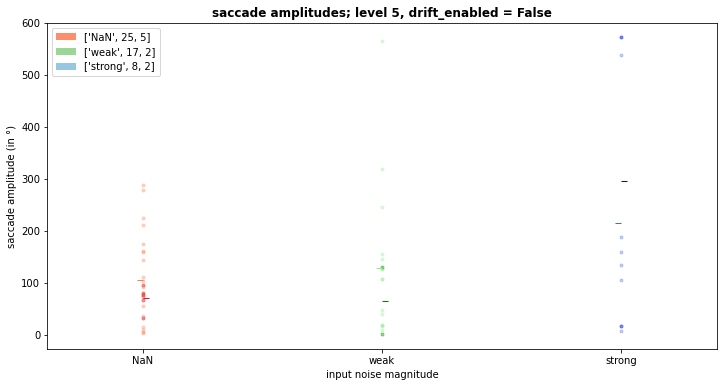

In [100]:
runs = [42, 35, 18]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"saccade amplitudes; level 5, drift_enabled = False", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("input noise magnitude")
ax.set_ylabel("saccade amplitude (in °)")

ax.set_xlim([-70, 70])
ax.set_xticks([-50, 0, 50])
ax.set_xticklabels(["NaN", "weak", "strong"])

# Plotting
colors = ["coral", "lightgreen", "royalblue"]
colors_p = ["crimson", "green", "blue"]
color_maps = ["Reds", "Greens", "Blues"]
input_noise_magnitude = ["NaN", "weak", "strong"]
offset = [-50, 0, 50]
n_saccades = [np.nan, np.nan, np.nan]
n_progressive_saccades = [np.nan, np.nan, np.nan]

counter = 0

for run in runs:
    eye_data = pd.read_csv(f'eye_data/pilot4_eye_tracking_output_{run:0>2}.csv', index_col=False)
    eye_data = pre_process_eye_data(eye_data)
    
    # all kinds of saccades
    saccades = eye_data[eye_data["saccadeOnset"] >= 1]
    n_saccades[counter] = len(saccades)
    plot_labels = [offset[counter]]* len(saccades)
    saccades["plot_label"] = [offset[counter]]* len(saccades)
    # progressive saccades
    progressive_saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
    n_progressive_saccades[counter] = len(progressive_saccades)
    
    # draw on canvas
    ax.scatter(saccades.plot_label, saccades.saccade_amplitude, marker=".", color=colors[counter], alpha=0.3)
    ax.plot(offset[counter], np.mean(saccades.saccade_amplitude), marker=0, color=colors[counter], alpha=1.0)
    
    ax.scatter(progressive_saccades.plot_label, progressive_saccades.saccade_amplitude, marker=".", color=colors_p[counter], alpha=0.3)
    ax.plot(offset[counter], np.mean(progressive_saccades.saccade_amplitude), marker=1, color=colors_p[counter], alpha=1.0)
    
    counter += 1

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=[input_noise_magnitude[0], n_saccades[0], n_progressive_saccades[0]]),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label=[input_noise_magnitude[1], n_saccades[1], n_progressive_saccades[1]]),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label=[input_noise_magnitude[2], n_saccades[2], n_progressive_saccades[2]])]
ax.legend(handles=handles)

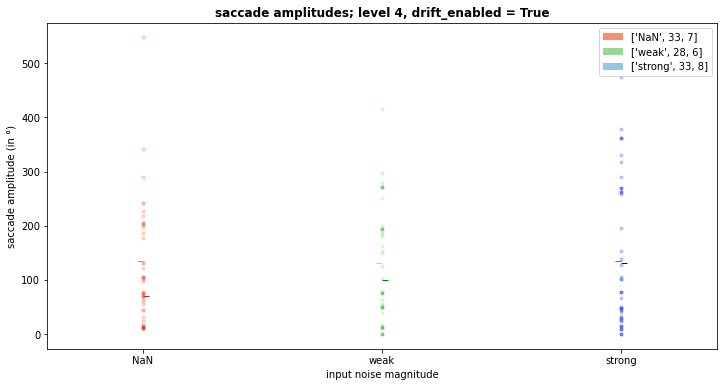

In [98]:
runs = [20, 22, 1]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"saccade amplitudes; level 4, drift_enabled = True", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("input noise magnitude")
ax.set_ylabel("saccade amplitude (in °)")

ax.set_xlim([-70, 70])
ax.set_xticks([-50, 0, 50])
ax.set_xticklabels(["NaN", "weak", "strong"])

# Plotting
colors = ["coral", "lightgreen", "royalblue"]
colors_p = ["crimson", "green", "blue"]
color_maps = ["Reds", "Greens", "Blues"]
input_noise_magnitude = ["NaN", "weak", "strong"]
offset = [-50, 0, 50]
n_saccades = [np.nan, np.nan, np.nan]
n_progressive_saccades = [np.nan, np.nan, np.nan]

counter = 0

for run in runs:
    eye_data = pd.read_csv(f'eye_data/pilot4_eye_tracking_output_{run:0>2}.csv', index_col=False)
    eye_data = pre_process_eye_data(eye_data)
    
    # all kinds of saccades
    saccades = eye_data[eye_data["saccadeOnset"] >= 1]
    n_saccades[counter] = len(saccades)
    plot_labels = [offset[counter]]* len(saccades)
    saccades["plot_label"] = [offset[counter]]* len(saccades)
    # progressive saccades
    progressive_saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
    n_progressive_saccades[counter] = len(progressive_saccades)
    
    # draw on canvas
    ax.scatter(saccades.plot_label, saccades.saccade_amplitude, marker=".", color=colors[counter], alpha=0.3)
    ax.plot(offset[counter], np.mean(saccades.saccade_amplitude), marker=0, color=colors[counter], alpha=1.0)
    
    ax.scatter(progressive_saccades.plot_label, progressive_saccades.saccade_amplitude, marker=".", color=colors_p[counter], alpha=0.3)
    ax.plot(offset[counter], np.mean(progressive_saccades.saccade_amplitude), marker=1, color=colors_p[counter], alpha=1.0)
    
    counter += 1

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=[input_noise_magnitude[0], n_saccades[0], n_progressive_saccades[0]]),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label=[input_noise_magnitude[1], n_saccades[1], n_progressive_saccades[1]]),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label=[input_noise_magnitude[2], n_saccades[2], n_progressive_saccades[2]])]
ax.legend(handles=handles)

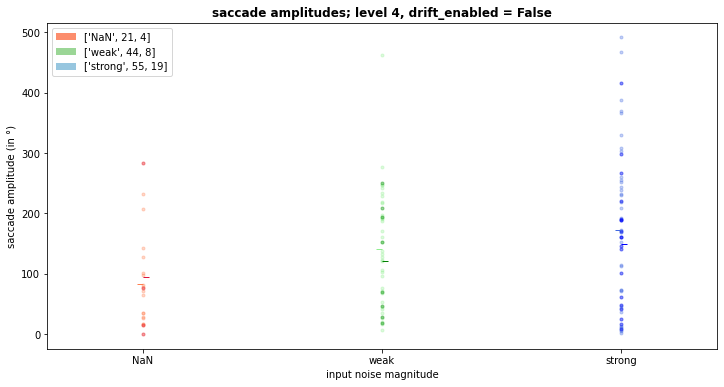

In [99]:
runs = [40, 19, 11]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f"saccade amplitudes; level 4, drift_enabled = False", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("input noise magnitude")
ax.set_ylabel("saccade amplitude (in °)")

ax.set_xlim([-70, 70])
ax.set_xticks([-50, 0, 50])
ax.set_xticklabels(["NaN", "weak", "strong"])

# Plotting
colors = ["coral", "lightgreen", "royalblue"]
colors_p = ["crimson", "green", "blue"]
color_maps = ["Reds", "Greens", "Blues"]
input_noise_magnitude = ["NaN", "weak", "strong"]
offset = [-50, 0, 50]
n_saccades = [np.nan, np.nan, np.nan]
n_progressive_saccades = [np.nan, np.nan, np.nan]

counter = 0

for run in runs:
    eye_data = pd.read_csv(f'eye_data/pilot4_eye_tracking_output_{run:0>2}.csv', index_col=False)
    eye_data = pre_process_eye_data(eye_data)
    
    # all kinds of saccades
    saccades = eye_data[eye_data["saccadeOnset"] >= 1]
    n_saccades[counter] = len(saccades)
    plot_labels = [offset[counter]]* len(saccades)
    saccades["plot_label"] = [offset[counter]]* len(saccades)
    # progressive saccades
    progressive_saccades = saccades.loc[saccades["saccade_direction_y"] >= 0]
    n_progressive_saccades[counter] = len(progressive_saccades)
    
    # draw on canvas
    ax.scatter(saccades.plot_label, saccades.saccade_amplitude, marker=".", color=colors[counter], alpha=0.3)
    ax.plot(offset[counter], np.mean(saccades.saccade_amplitude), marker=0, color=colors[counter], alpha=1.0)
    
    ax.scatter(progressive_saccades.plot_label, progressive_saccades.saccade_amplitude, marker=".", color=colors_p[counter], alpha=0.3)
    ax.plot(offset[counter], np.mean(progressive_saccades.saccade_amplitude), marker=1, color=colors_p[counter], alpha=1.0)
    
    counter += 1

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label=[input_noise_magnitude[0], n_saccades[0], n_progressive_saccades[0]]),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label=[input_noise_magnitude[1], n_saccades[1], n_progressive_saccades[1]]),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label=[input_noise_magnitude[2], n_saccades[2], n_progressive_saccades[2]])]
ax.legend(handles=handles)